# Clusteranalyse auf PCA-Scores

Diese Analyse führt das Clustering auf den PCA-Koordinaten durch (statt auf den Rohdaten).

**Vorteile:**
- Reduziert Dimensionalität (223 → 2-3)
- Entfernt Rauschen
- Konzentriert sich auf die Hauptvarianz
- Oft bessere Cluster-Trennung

---

## 1. Setup und Daten laden

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
sns.set_style('whitegrid')

DB_PATH = '../data/processed/swiss_votings.db'
conn = sqlite3.connect(DB_PATH)
print("Setup abgeschlossen.")

Setup abgeschlossen.


In [2]:
# Daten laden und vorbereiten (wie im PCA-Notebook)
query = """
SELECT municipality_id, municipality_name, proposal_id, ja_prozent
FROM v_voting_results_analysis
WHERE ja_prozent IS NOT NULL
"""
df_raw = pd.read_sql_query(query, conn)

# Pivot
df_pivot = df_raw.pivot_table(
    index=['municipality_id', 'municipality_name'],
    columns='proposal_id',
    values='ja_prozent',
    aggfunc='first'
)

# Filtern
MAX_MISSING = 0.20
missing_prop = df_pivot.isnull().sum(axis=0)
valid_props = missing_prop[missing_prop <= df_pivot.shape[0] * MAX_MISSING].index
df_filtered = df_pivot[valid_props]

missing_mun = df_filtered.isnull().sum(axis=1)
valid_mun = missing_mun[missing_mun <= df_filtered.shape[1] * MAX_MISSING].index
df_filtered = df_filtered.loc[valid_mun]

# Imputation und Standardisierung
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(df_filtered)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

print(f"Daten vorbereitet: {X_scaled.shape[0]} Gemeinden × {X_scaled.shape[1]} Vorlagen")

Daten vorbereitet: 2109 Gemeinden × 223 Vorlagen


In [3]:
# PCA berechnen
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Auch 2D-Version für Vergleich
X_pca_2d = X_pca[:, :2]

# DataFrame erstellen
df_pca = pd.DataFrame(
    X_pca,
    columns=['PC1', 'PC2', 'PC3'],
    index=df_filtered.index
).reset_index()

print(f"PCA berechnet:")
print(f"  PC1: {pca.explained_variance_ratio_[0]*100:.1f}% (Liberal ↔ Konservativ)")
print(f"  PC2: {pca.explained_variance_ratio_[1]*100:.1f}% (Establishment ↔ Populistisch)")
print(f"  PC3: {pca.explained_variance_ratio_[2]*100:.1f}% (Ökologisch ↔ Technokratisch)")
print(f"  Total: {pca.explained_variance_ratio_.sum()*100:.1f}%")

PCA berechnet:
  PC1: 35.9% (Liberal ↔ Konservativ)
  PC2: 14.1% (Establishment ↔ Populistisch)
  PC3: 9.0% (Ökologisch ↔ Technokratisch)
  Total: 59.0%


## 2. Optimale Clusteranzahl bestimmen

In [4]:
# Metriken für 2D und 3D PCA-Clustering
k_range = range(2, 12)

results = {'2D': {'inertia': [], 'silhouette': [], 'calinski': [], 'davies': []},
           '3D': {'inertia': [], 'silhouette': [], 'calinski': [], 'davies': []}}

for k in k_range:
    # 2D
    km_2d = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_2d = km_2d.fit_predict(X_pca_2d)
    results['2D']['inertia'].append(km_2d.inertia_)
    results['2D']['silhouette'].append(silhouette_score(X_pca_2d, labels_2d))
    results['2D']['calinski'].append(calinski_harabasz_score(X_pca_2d, labels_2d))
    results['2D']['davies'].append(davies_bouldin_score(X_pca_2d, labels_2d))
    
    # 3D
    km_3d = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_3d = km_3d.fit_predict(X_pca)
    results['3D']['inertia'].append(km_3d.inertia_)
    results['3D']['silhouette'].append(silhouette_score(X_pca, labels_3d))
    results['3D']['calinski'].append(calinski_harabasz_score(X_pca, labels_3d))
    results['3D']['davies'].append(davies_bouldin_score(X_pca, labels_3d))

print("Metriken berechnet.")

Metriken berechnet.


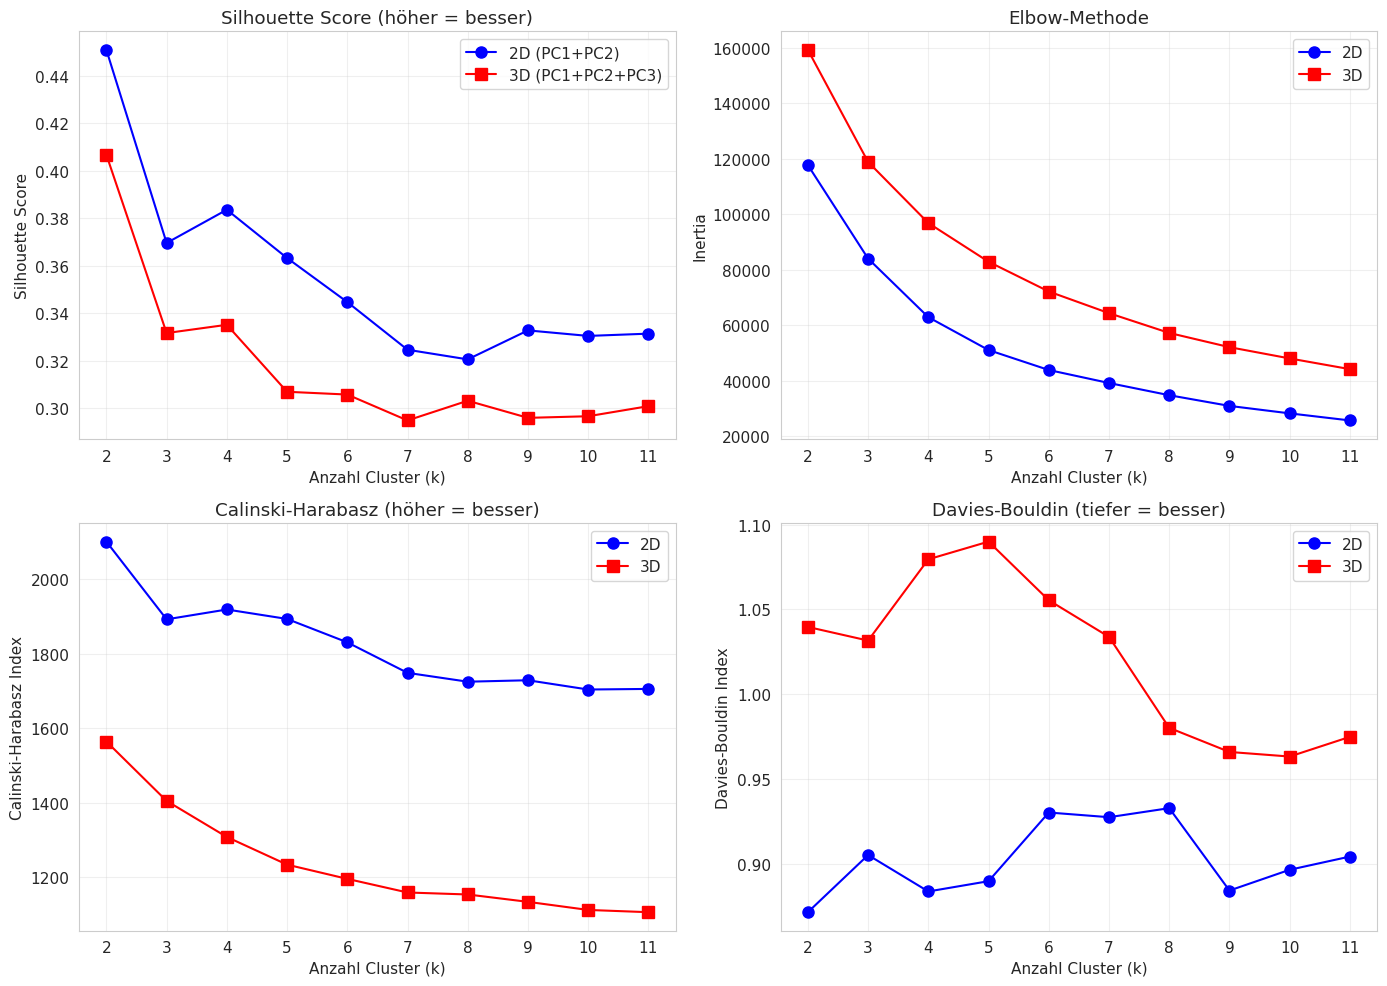


Bester Silhouette Score:
  2D: k=2 (Sil=0.451)
  3D: k=2 (Sil=0.407)


In [5]:
# Visualisierung der Metriken
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Silhouette (2D vs 3D)
axes[0, 0].plot(k_range, results['2D']['silhouette'], 'bo-', label='2D (PC1+PC2)', markersize=8)
axes[0, 0].plot(k_range, results['3D']['silhouette'], 'rs-', label='3D (PC1+PC2+PC3)', markersize=8)
axes[0, 0].set_xlabel('Anzahl Cluster (k)')
axes[0, 0].set_ylabel('Silhouette Score')
axes[0, 0].set_title('Silhouette Score (höher = besser)')
axes[0, 0].legend()
axes[0, 0].set_xticks(list(k_range))
axes[0, 0].grid(True, alpha=0.3)

# Elbow (Inertia)
axes[0, 1].plot(k_range, results['2D']['inertia'], 'bo-', label='2D', markersize=8)
axes[0, 1].plot(k_range, results['3D']['inertia'], 'rs-', label='3D', markersize=8)
axes[0, 1].set_xlabel('Anzahl Cluster (k)')
axes[0, 1].set_ylabel('Inertia')
axes[0, 1].set_title('Elbow-Methode')
axes[0, 1].legend()
axes[0, 1].set_xticks(list(k_range))
axes[0, 1].grid(True, alpha=0.3)

# Calinski-Harabasz
axes[1, 0].plot(k_range, results['2D']['calinski'], 'bo-', label='2D', markersize=8)
axes[1, 0].plot(k_range, results['3D']['calinski'], 'rs-', label='3D', markersize=8)
axes[1, 0].set_xlabel('Anzahl Cluster (k)')
axes[1, 0].set_ylabel('Calinski-Harabasz Index')
axes[1, 0].set_title('Calinski-Harabasz (höher = besser)')
axes[1, 0].legend()
axes[1, 0].set_xticks(list(k_range))
axes[1, 0].grid(True, alpha=0.3)

# Davies-Bouldin
axes[1, 1].plot(k_range, results['2D']['davies'], 'bo-', label='2D', markersize=8)
axes[1, 1].plot(k_range, results['3D']['davies'], 'rs-', label='3D', markersize=8)
axes[1, 1].set_xlabel('Anzahl Cluster (k)')
axes[1, 1].set_ylabel('Davies-Bouldin Index')
axes[1, 1].set_title('Davies-Bouldin (tiefer = besser)')
axes[1, 1].legend()
axes[1, 1].set_xticks(list(k_range))
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('pca_cluster_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

# Beste k-Werte
best_k_2d = list(k_range)[np.argmax(results['2D']['silhouette'])]
best_k_3d = list(k_range)[np.argmax(results['3D']['silhouette'])]
print(f"\nBester Silhouette Score:")
print(f"  2D: k={best_k_2d} (Sil={max(results['2D']['silhouette']):.3f})")
print(f"  3D: k={best_k_3d} (Sil={max(results['3D']['silhouette']):.3f})")

## 3. K-Means auf 2D PCA

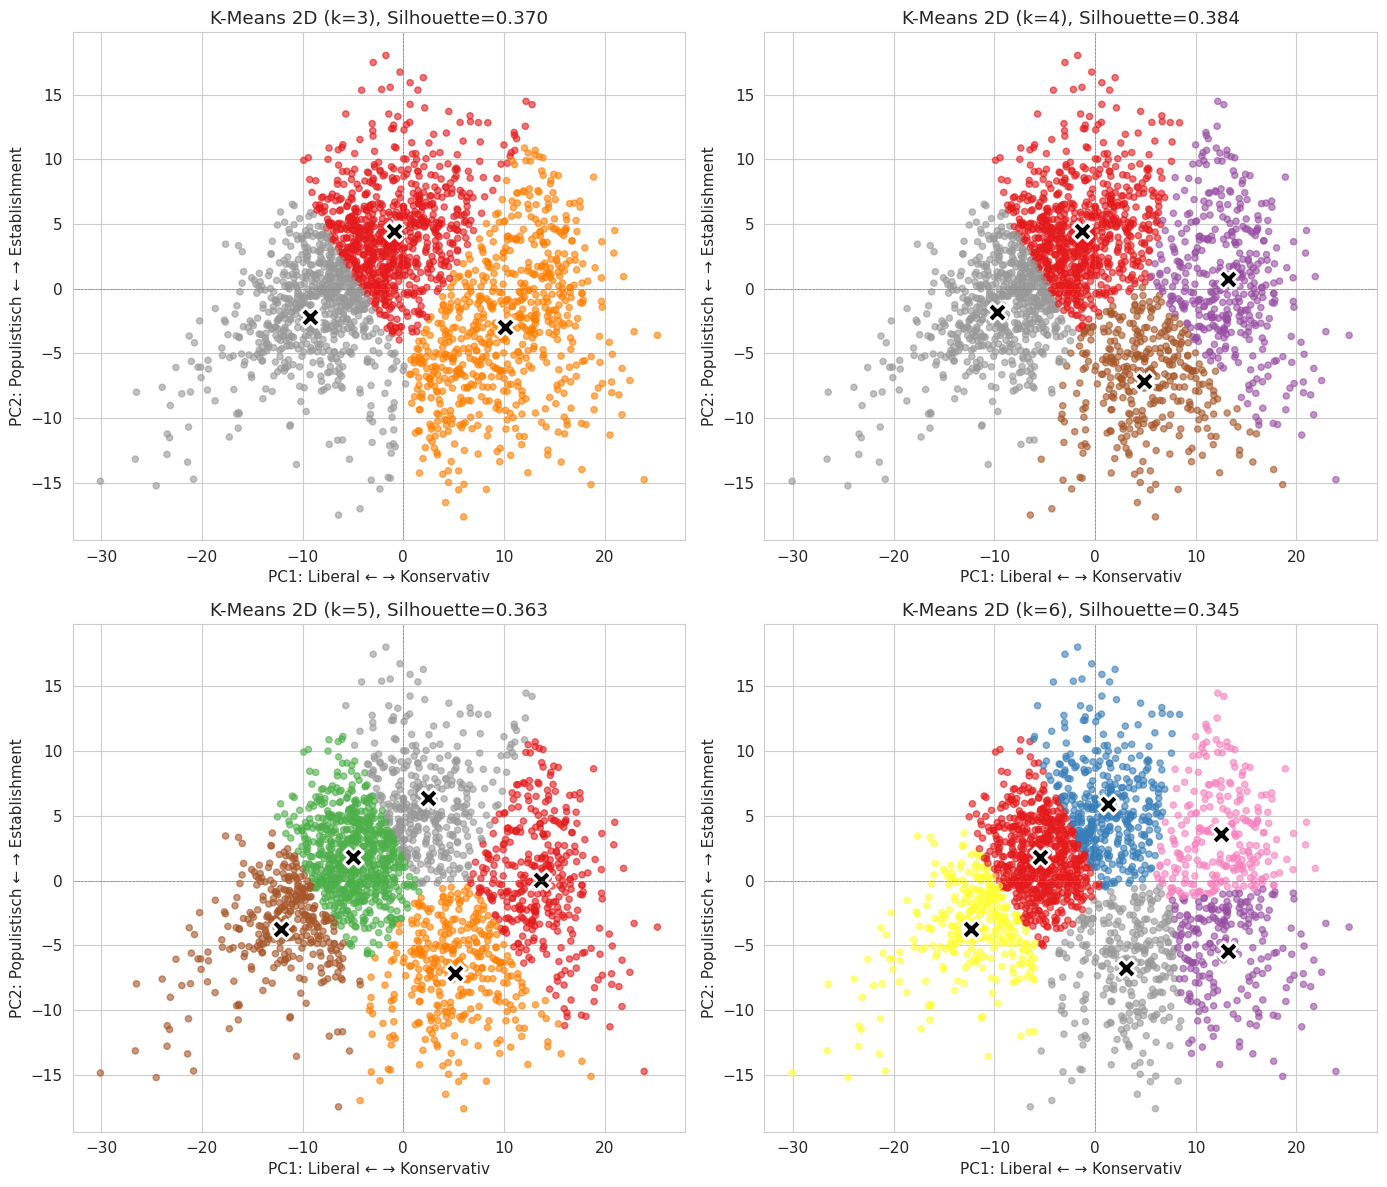

In [6]:
# K-Means auf 2D PCA mit verschiedenen k
k_values = [3, 4, 5, 6]

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for i, k in enumerate(k_values):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_pca_2d)
    sil = silhouette_score(X_pca_2d, labels)
    
    # Plot
    scatter = axes[i].scatter(
        df_pca['PC1'], df_pca['PC2'],
        c=labels, cmap='Set1', alpha=0.6, s=20
    )
    
    # Zentren
    axes[i].scatter(
        kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
        c='black', marker='X', s=200, edgecolors='white', linewidths=2
    )
    
    axes[i].set_xlabel('PC1: Liberal ← → Konservativ')
    axes[i].set_ylabel('PC2: Populistisch ← → Establishment')
    axes[i].set_title(f'K-Means 2D (k={k}), Silhouette={sil:.3f}')
    axes[i].axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
    axes[i].axvline(x=0, color='gray', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig('kmeans_2d_pca.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. K-Means auf 3D PCA

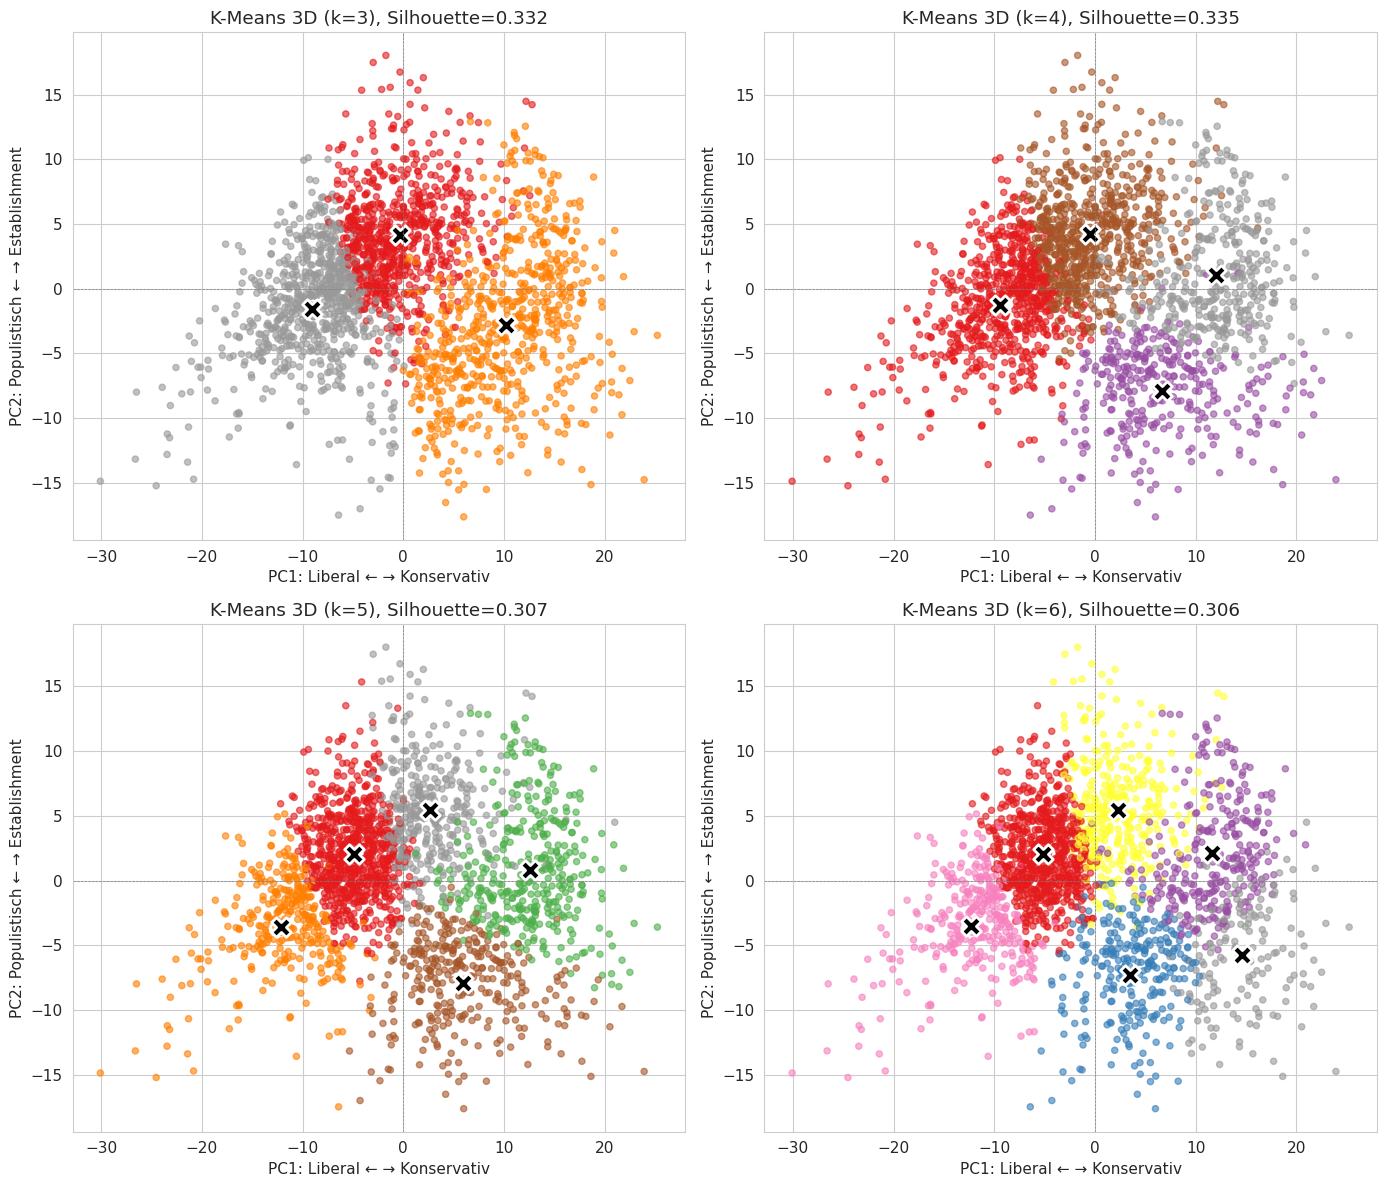

In [7]:
# K-Means auf 3D PCA
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

kmeans_3d_results = {}

for i, k in enumerate(k_values):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_pca)
    kmeans_3d_results[k] = labels
    sil = silhouette_score(X_pca, labels)
    
    scatter = axes[i].scatter(
        df_pca['PC1'], df_pca['PC2'],
        c=labels, cmap='Set1', alpha=0.6, s=20
    )
    
    # Zentren projiziert auf 2D
    axes[i].scatter(
        kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
        c='black', marker='X', s=200, edgecolors='white', linewidths=2
    )
    
    axes[i].set_xlabel('PC1: Liberal ← → Konservativ')
    axes[i].set_ylabel('PC2: Populistisch ← → Establishment')
    axes[i].set_title(f'K-Means 3D (k={k}), Silhouette={sil:.3f}')
    axes[i].axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
    axes[i].axvline(x=0, color='gray', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig('kmeans_3d_pca.png', dpi=150, bbox_inches='tight')
plt.show()

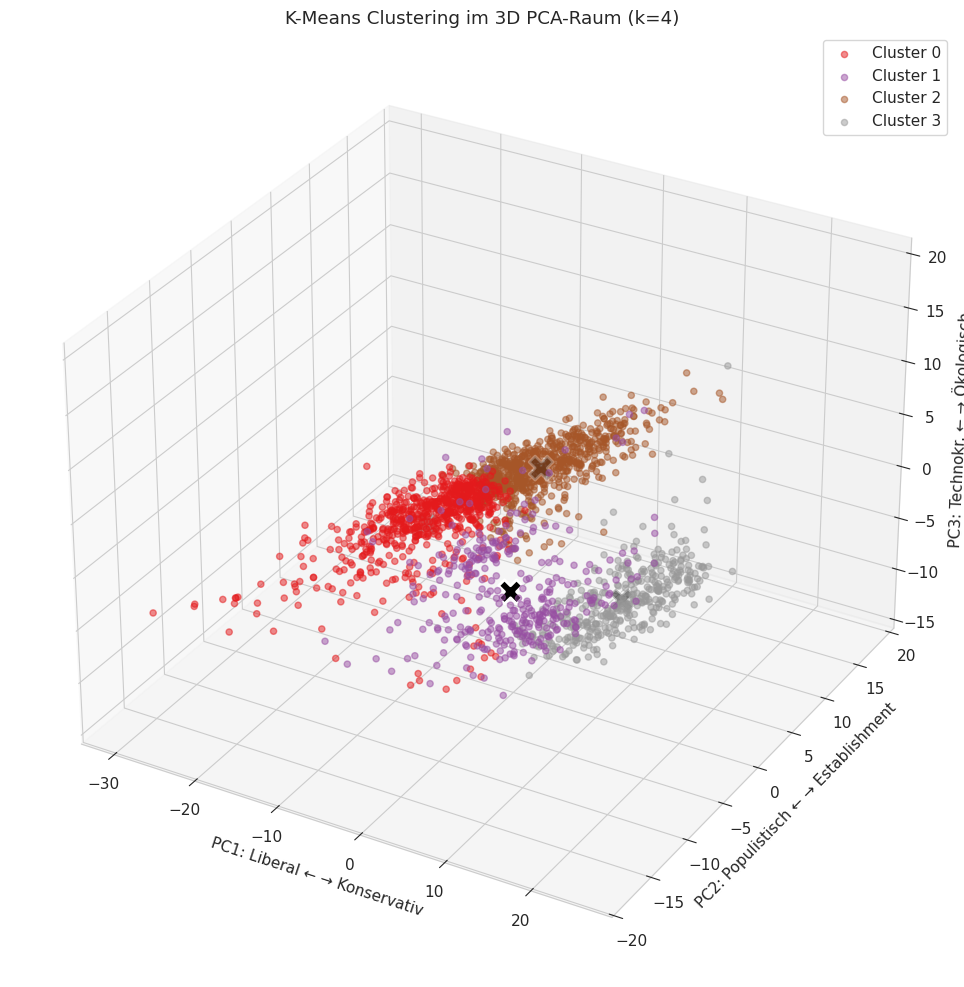

K-Means auf 3D PCA (k=4): Silhouette = 0.335


In [8]:
# 3D-Visualisierung mit bestem k
from mpl_toolkits.mplot3d import Axes3D

BEST_K = 4  # Anpassen nach obiger Analyse

kmeans_best = KMeans(n_clusters=BEST_K, random_state=42, n_init=10)
df_pca['cluster'] = kmeans_best.fit_predict(X_pca)

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

colors = plt.cm.Set1(np.linspace(0, 1, BEST_K))

for cluster in range(BEST_K):
    mask = df_pca['cluster'] == cluster
    ax.scatter(
        df_pca.loc[mask, 'PC1'],
        df_pca.loc[mask, 'PC2'],
        df_pca.loc[mask, 'PC3'],
        c=[colors[cluster]], alpha=0.5, s=20, label=f'Cluster {cluster}'
    )

# Zentren
centers = kmeans_best.cluster_centers_
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2],
           c='black', marker='X', s=300, edgecolors='white', linewidths=2)

ax.set_xlabel('PC1: Liberal ← → Konservativ')
ax.set_ylabel('PC2: Populistisch ← → Establishment')
ax.set_zlabel('PC3: Technokr. ← → Ökologisch')
ax.set_title(f'K-Means Clustering im 3D PCA-Raum (k={BEST_K})')
ax.legend()

plt.tight_layout()
plt.savefig('kmeans_3d_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

sil = silhouette_score(X_pca, df_pca['cluster'])
print(f"K-Means auf 3D PCA (k={BEST_K}): Silhouette = {sil:.3f}")

## 5. Hierarchisches Clustering auf PCA

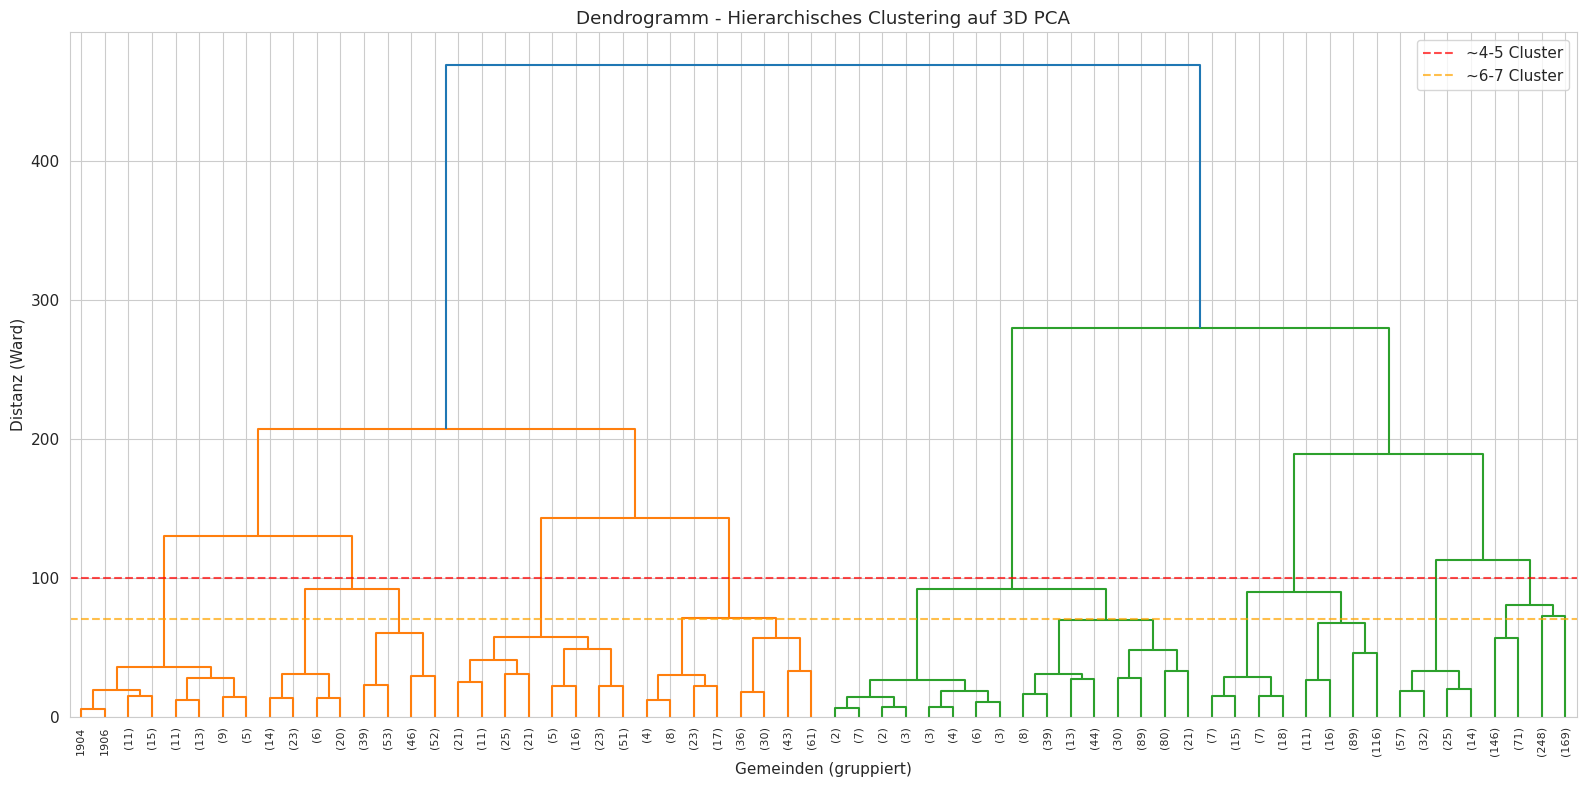

In [9]:
# Dendrogramm auf 3D PCA
Z = linkage(X_pca, method='ward')

fig, ax = plt.subplots(figsize=(16, 8))
dendrogram(Z, truncate_mode='level', p=5, leaf_rotation=90, leaf_font_size=8, ax=ax)
ax.set_xlabel('Gemeinden (gruppiert)')
ax.set_ylabel('Distanz (Ward)')
ax.set_title('Dendrogramm - Hierarchisches Clustering auf 3D PCA')

# Horizontale Linien für Cluster-Schnitte
ax.axhline(y=100, color='red', linestyle='--', alpha=0.7, label='~4-5 Cluster')
ax.axhline(y=70, color='orange', linestyle='--', alpha=0.7, label='~6-7 Cluster')
ax.legend()

plt.tight_layout()
plt.savefig('hierarchical_pca_dendrogram.png', dpi=150, bbox_inches='tight')
plt.show()

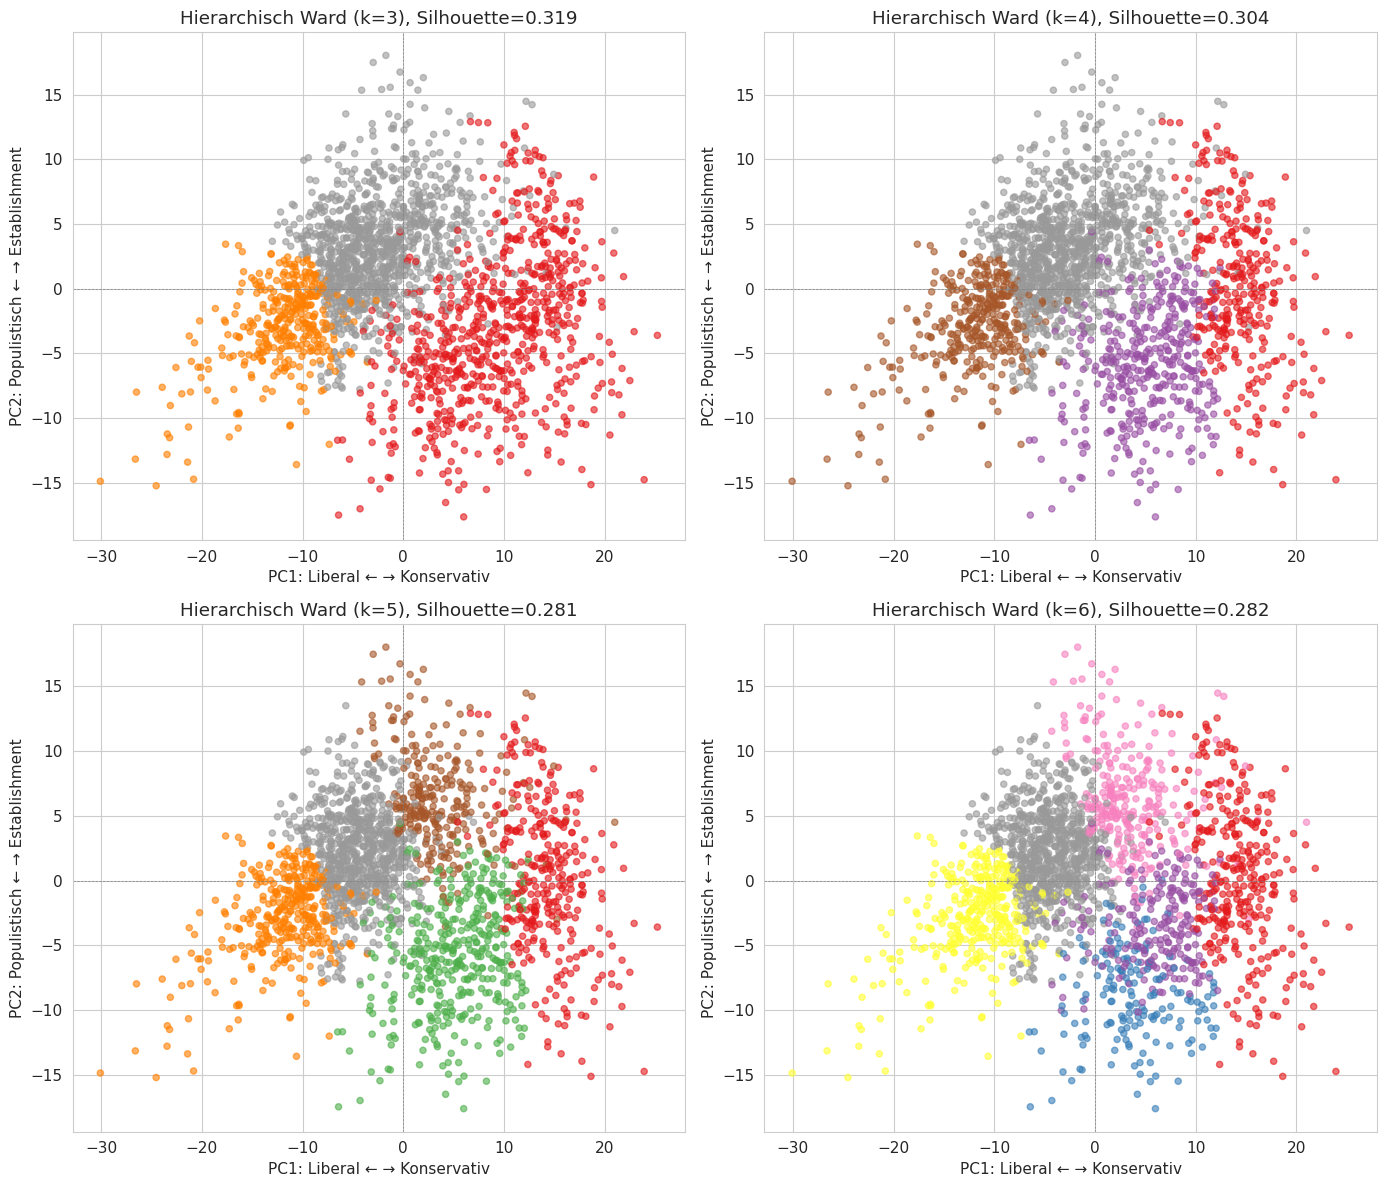

In [10]:
# Hierarchisches Clustering mit verschiedenen k
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for i, k in enumerate(k_values):
    labels = fcluster(Z, k, criterion='maxclust') - 1
    sil = silhouette_score(X_pca, labels)
    
    scatter = axes[i].scatter(
        df_pca['PC1'], df_pca['PC2'],
        c=labels, cmap='Set1', alpha=0.6, s=20
    )
    
    axes[i].set_xlabel('PC1: Liberal ← → Konservativ')
    axes[i].set_ylabel('PC2: Populistisch ← → Establishment')
    axes[i].set_title(f'Hierarchisch Ward (k={k}), Silhouette={sil:.3f}')
    axes[i].axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
    axes[i].axvline(x=0, color='gray', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig('hierarchical_pca_clustering.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. GMM auf PCA

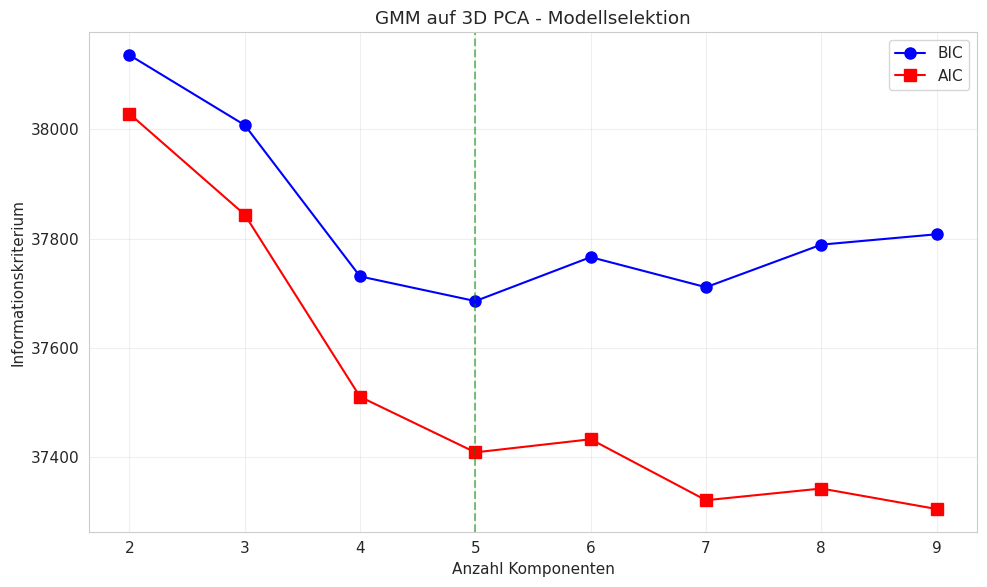

Optimale Komponentenzahl nach BIC: 5


In [11]:
# GMM Modellselektion auf 3D PCA
n_range = range(2, 10)
bics = []
aics = []

for n in n_range:
    gmm = GaussianMixture(n_components=n, random_state=42, n_init=5)
    gmm.fit(X_pca)
    bics.append(gmm.bic(X_pca))
    aics.append(gmm.aic(X_pca))

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(n_range, bics, 'bo-', label='BIC', markersize=8)
ax.plot(n_range, aics, 'rs-', label='AIC', markersize=8)
ax.set_xlabel('Anzahl Komponenten')
ax.set_ylabel('Informationskriterium')
ax.set_title('GMM auf 3D PCA - Modellselektion')
ax.legend()
ax.set_xticks(list(n_range))
ax.grid(True, alpha=0.3)

best_n = list(n_range)[np.argmin(bics)]
ax.axvline(x=best_n, color='green', linestyle='--', alpha=0.5, label=f'Best BIC: {best_n}')

plt.tight_layout()
plt.savefig('gmm_pca_selection.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Optimale Komponentenzahl nach BIC: {best_n}")

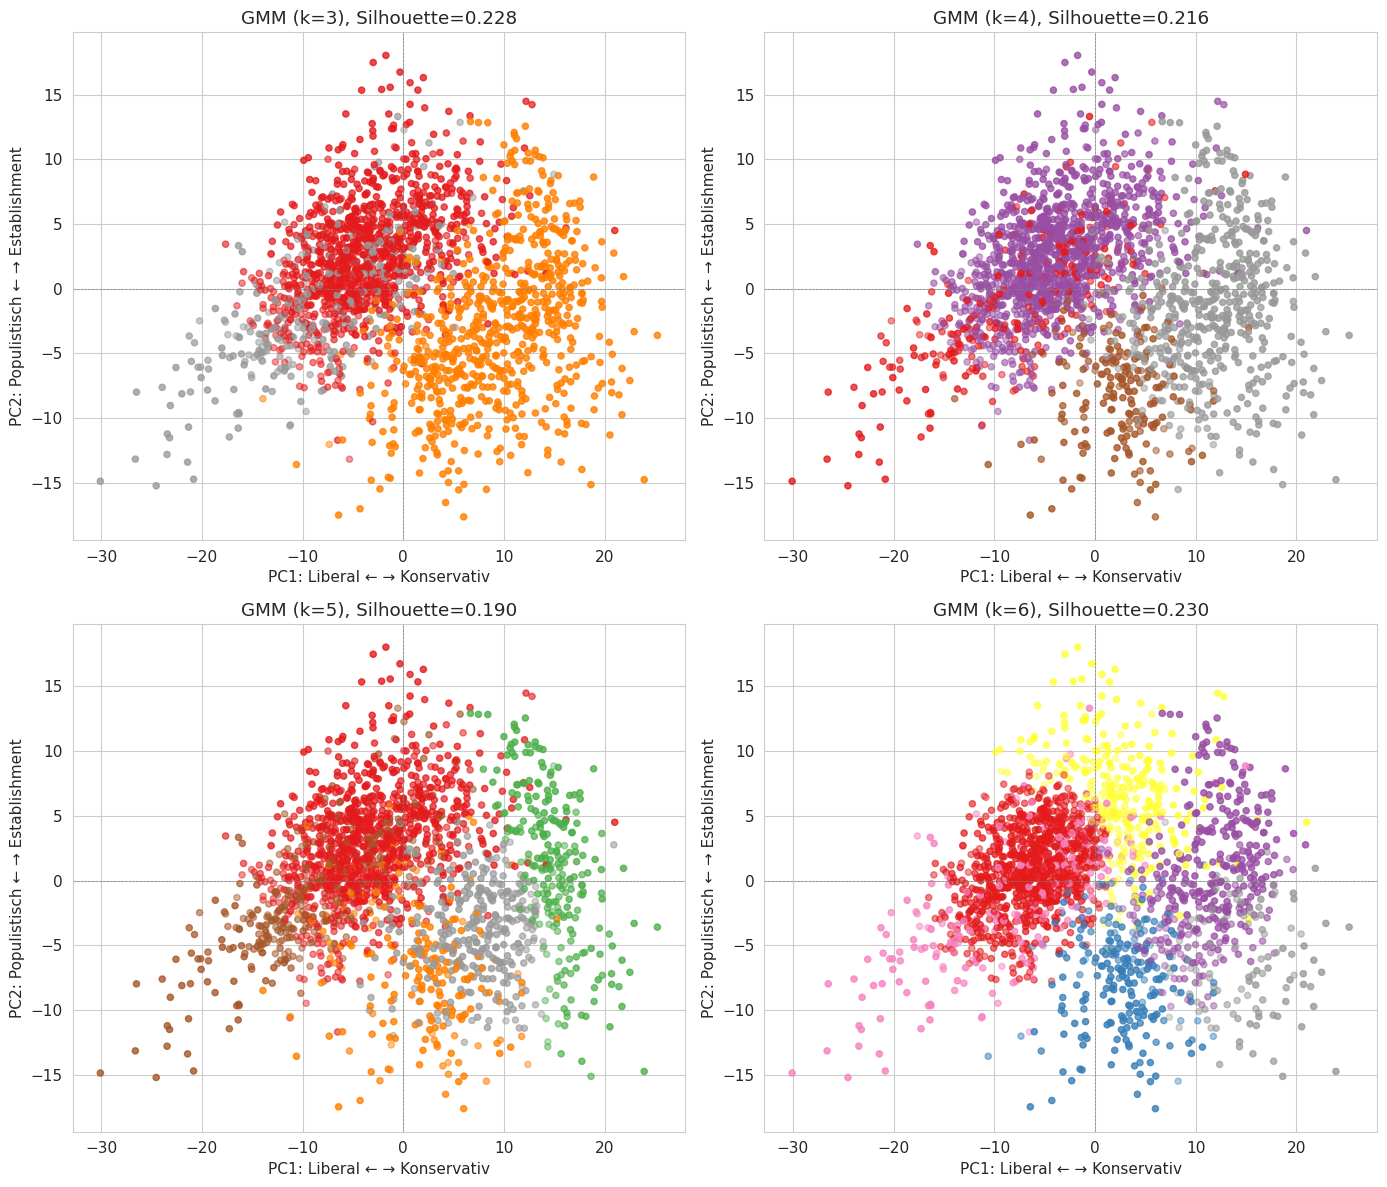

In [12]:
# GMM mit verschiedenen k
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for i, k in enumerate(k_values):
    gmm = GaussianMixture(n_components=k, random_state=42, n_init=5)
    labels = gmm.fit_predict(X_pca)
    probs = gmm.predict_proba(X_pca).max(axis=1)
    sil = silhouette_score(X_pca, labels)
    
    # Transparenz nach Zugehörigkeits-Wahrscheinlichkeit
    scatter = axes[i].scatter(
        df_pca['PC1'], df_pca['PC2'],
        c=labels, cmap='Set1', alpha=probs*0.7+0.1, s=20
    )
    
    axes[i].set_xlabel('PC1: Liberal ← → Konservativ')
    axes[i].set_ylabel('PC2: Populistisch ← → Establishment')
    axes[i].set_title(f'GMM (k={k}), Silhouette={sil:.3f}')
    axes[i].axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
    axes[i].axvline(x=0, color='gray', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig('gmm_pca_clustering.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Vergleich: Rohdaten vs PCA-Clustering

In [13]:
# Vergleich der Silhouette Scores
print("="*70)
print("VERGLEICH: ROHDATEN vs PCA-CLUSTERING (K-Means, k=4)")
print("="*70)

# Rohdaten
km_raw = KMeans(n_clusters=4, random_state=42, n_init=10)
labels_raw = km_raw.fit_predict(X_scaled)
sil_raw = silhouette_score(X_scaled, labels_raw)

# 2D PCA
km_2d = KMeans(n_clusters=4, random_state=42, n_init=10)
labels_2d = km_2d.fit_predict(X_pca_2d)
sil_2d = silhouette_score(X_pca_2d, labels_2d)

# 3D PCA
km_3d = KMeans(n_clusters=4, random_state=42, n_init=10)
labels_3d = km_3d.fit_predict(X_pca)
sil_3d = silhouette_score(X_pca, labels_3d)

print(f"\n{'Datengrundlage':<25} {'Dimensionen':>15} {'Silhouette':>15}")
print("-"*60)
print(f"{'Rohdaten':<25} {X_scaled.shape[1]:>15} {sil_raw:>15.3f}")
print(f"{'PCA 2D':<25} {'2':>15} {sil_2d:>15.3f}")
print(f"{'PCA 3D':<25} {'3':>15} {sil_3d:>15.3f}")

print(f"\n→ Verbesserung durch PCA 3D: {((sil_3d - sil_raw) / sil_raw * 100):+.1f}%")

VERGLEICH: ROHDATEN vs PCA-CLUSTERING (K-Means, k=4)



Datengrundlage                Dimensionen      Silhouette
------------------------------------------------------------
Rohdaten                              223           0.167
PCA 2D                                  2           0.384
PCA 3D                                  3           0.335

→ Verbesserung durch PCA 3D: +100.4%


## 8. Finale Analyse mit bestem Setup

In [14]:
# Finale Cluster-Zuordnung (K-Means auf 3D PCA)
FINAL_K = 4

kmeans_final = KMeans(n_clusters=FINAL_K, random_state=42, n_init=10)
df_pca['final_cluster'] = kmeans_final.fit_predict(X_pca)

print(f"Finale Clustering-Konfiguration:")
print(f"  Methode: K-Means")
print(f"  Daten: 3D PCA (PC1, PC2, PC3)")
print(f"  Anzahl Cluster: {FINAL_K}")
print(f"  Silhouette Score: {silhouette_score(X_pca, df_pca['final_cluster']):.3f}")
print(f"\nCluster-Grössen:")
print(df_pca['final_cluster'].value_counts().sort_index())

Finale Clustering-Konfiguration:
  Methode: K-Means
  Daten: 3D PCA (PC1, PC2, PC3)
  Anzahl Cluster: 4
  Silhouette Score: 0.335

Cluster-Grössen:
final_cluster
0    683
1    330
2    719
3    377
Name: count, dtype: int64


In [15]:
# Cluster-Profile
print("="*80)
print("CLUSTER-PROFILE")
print("="*80)

cluster_profiles = []

for cluster in range(FINAL_K):
    members = df_pca[df_pca['final_cluster'] == cluster]
    
    pc1_mean = members['PC1'].mean()
    pc2_mean = members['PC2'].mean()
    pc3_mean = members['PC3'].mean()
    
    # Interpretation
    if pc1_mean > 10:
        lib_kon = "SEHR LIBERAL"
    elif pc1_mean > 3:
        lib_kon = "liberal"
    elif pc1_mean < -10:
        lib_kon = "SEHR KONSERVATIV"
    elif pc1_mean < -3:
        lib_kon = "konservativ"
    else:
        lib_kon = "moderat"
    
    if pc2_mean > 5:
        est_pop = "establishment"
    elif pc2_mean < -5:
        est_pop = "populistisch"
    else:
        est_pop = "gemischt"
    
    if pc3_mean > 5:
        oeko = "ökologisch"
    elif pc3_mean < -3:
        oeko = "technokratisch"
    else:
        oeko = "neutral"
    
    profile = f"{lib_kon}, {est_pop}, {oeko}"
    cluster_profiles.append(profile)
    
    print(f"\n{'-'*70}")
    print(f"CLUSTER {cluster}: {profile.upper()}")
    print(f"{'-'*70}")
    print(f"  Grösse: {len(members)} Gemeinden ({len(members)/len(df_pca)*100:.1f}%)")
    print(f"  PC1 (Lib-Kon): {pc1_mean:+.1f}")
    print(f"  PC2 (Est-Pop): {pc2_mean:+.1f}")
    print(f"  PC3 (Öko-Tec): {pc3_mean:+.1f}")
    
    # Typische Gemeinden
    members = members.copy()
    members['dist'] = np.sqrt(
        (members['PC1'] - pc1_mean)**2 + 
        (members['PC2'] - pc2_mean)**2 +
        (members['PC3'] - pc3_mean)**2
    )
    print(f"\n  Typische Gemeinden:")
    for _, row in members.nsmallest(10, 'dist').iterrows():
        print(f"    - {row['municipality_name']}")

CLUSTER-PROFILE

----------------------------------------------------------------------
CLUSTER 0: KONSERVATIV, GEMISCHT, NEUTRAL
----------------------------------------------------------------------
  Grösse: 683 Gemeinden (32.4%)
  PC1 (Lib-Kon): -9.4
  PC2 (Est-Pop): -1.2
  PC3 (Öko-Tec): -0.9

  Typische Gemeinden:
    - Laupersdorf
    - Oberegg
    - Seelisberg
    - Merishausen
    - Schattdorf
    - Arni (BE)
    - Pfäfers
    - Bürglen (UR)
    - Densbüren
    - Wimmis

----------------------------------------------------------------------
CLUSTER 1: LIBERAL, POPULISTISCH, NEUTRAL
----------------------------------------------------------------------
  Grösse: 330 Gemeinden (15.6%)
  PC1 (Lib-Kon): +6.7
  PC2 (Est-Pop): -7.9
  PC3 (Öko-Tec): +0.6

  Typische Gemeinden:
    - Châtel-sur-Montsalvens
    - Nods
    - Péry-La Heutte
    - Billens-Hennens
    - Nuvilly
    - Belmont-Broye
    - Crésuz
    - Soyhières
    - Le Mouret
    - La Baroche

------------------------------

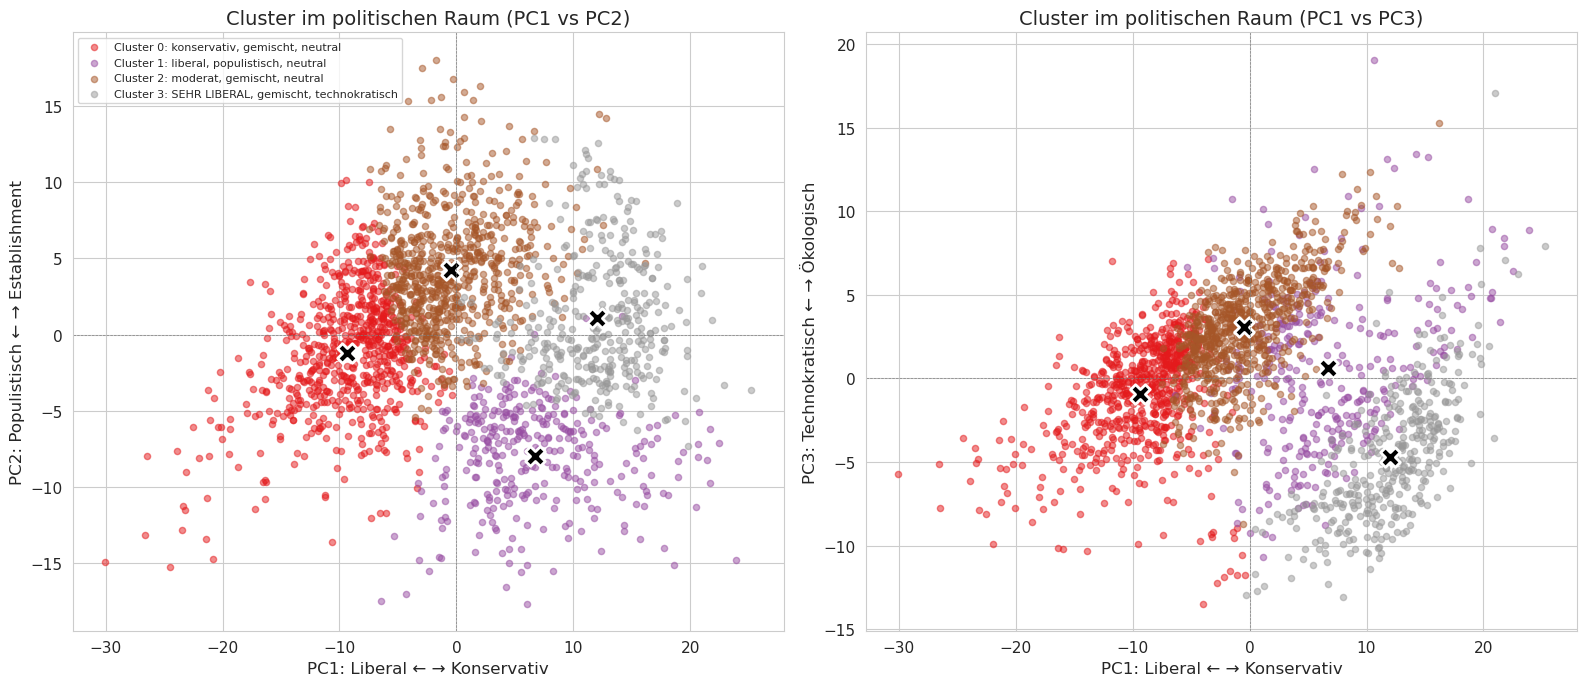

In [16]:
# Finale Visualisierung mit Cluster-Labels
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

colors = plt.cm.Set1(np.linspace(0, 1, FINAL_K))

# PC1 vs PC2
for cluster in range(FINAL_K):
    mask = df_pca['final_cluster'] == cluster
    axes[0].scatter(
        df_pca.loc[mask, 'PC1'], df_pca.loc[mask, 'PC2'],
        c=[colors[cluster]], alpha=0.5, s=20,
        label=f'Cluster {cluster}: {cluster_profiles[cluster]}'
    )

# Zentren
centers = kmeans_final.cluster_centers_
axes[0].scatter(centers[:, 0], centers[:, 1], c='black', marker='X', s=200, edgecolors='white', linewidths=2)

axes[0].set_xlabel('PC1: Liberal ← → Konservativ', fontsize=12)
axes[0].set_ylabel('PC2: Populistisch ← → Establishment', fontsize=12)
axes[0].set_title('Cluster im politischen Raum (PC1 vs PC2)', fontsize=14)
axes[0].axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
axes[0].axvline(x=0, color='gray', linestyle='--', linewidth=0.5)
axes[0].legend(loc='upper left', fontsize=8)

# PC1 vs PC3
for cluster in range(FINAL_K):
    mask = df_pca['final_cluster'] == cluster
    axes[1].scatter(
        df_pca.loc[mask, 'PC1'], df_pca.loc[mask, 'PC3'],
        c=[colors[cluster]], alpha=0.5, s=20,
        label=f'Cluster {cluster}'
    )

axes[1].scatter(centers[:, 0], centers[:, 2], c='black', marker='X', s=200, edgecolors='white', linewidths=2)

axes[1].set_xlabel('PC1: Liberal ← → Konservativ', fontsize=12)
axes[1].set_ylabel('PC3: Technokratisch ← → Ökologisch', fontsize=12)
axes[1].set_title('Cluster im politischen Raum (PC1 vs PC3)', fontsize=14)
axes[1].axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
axes[1].axvline(x=0, color='gray', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig('final_pca_clustering.png', dpi=150, bbox_inches='tight')
plt.show()

In [17]:
# Bekannte Gemeinden und ihre Cluster
print("="*70)
print("BEKANNTE GEMEINDEN UND IHRE CLUSTER-ZUORDNUNG")
print("="*70)

known = ['Zürich', 'Bern', 'Basel', 'Genève', 'Lausanne', 'Zug', 
         'Zumikon', 'Küsnacht', 'Muotathal', 'Unteriberg', 'Schwyz',
         'Luzern', 'St. Gallen', 'Winterthur', 'Lugano', 'Fribourg']

print(f"\n{'Gemeinde':<20} {'Cluster':>8} {'PC1':>8} {'PC2':>8} {'PC3':>8}  Profil")
print("-"*80)

for city in known:
    match = df_pca[df_pca['municipality_name'].str.contains(city, case=False, na=False)]
    if len(match) > 0:
        row = match.iloc[0]
        c = int(row['final_cluster'])
        print(f"{row['municipality_name']:<20} {c:>8} {row['PC1']:>8.1f} {row['PC2']:>8.1f} {row['PC3']:>8.1f}  {cluster_profiles[c]}")

BEKANNTE GEMEINDEN UND IHRE CLUSTER-ZUORDNUNG

Gemeinde              Cluster      PC1      PC2      PC3  Profil
--------------------------------------------------------------------------------
Zürich                      2     16.2      4.7     15.3  moderat, gemischt, neutral
Berneck                     2     -5.2      5.1      0.8  moderat, gemischt, neutral
Basel                       1     14.2      1.2     13.5  liberal, populistisch, neutral
Genève                      1     20.8     -5.1      8.9  liberal, populistisch, neutral
Belmont-sur-Lausanne        3     17.2      4.4     -3.7  SEHR LIBERAL, gemischt, technokratisch
Zug                         2      2.3     10.1      3.2  moderat, gemischt, neutral
Zumikon                     2     -1.7     18.0     -3.0  moderat, gemischt, neutral
Küsnacht (ZH)               2     -1.3     15.6     -0.8  moderat, gemischt, neutral
Muotathal                   0    -26.5     -8.0     -7.7  konservativ, gemischt, neutral
Unteriberg        

## 9. Export

In [18]:
# Export
export_df = df_pca[['municipality_id', 'municipality_name', 'PC1', 'PC2', 'PC3', 'final_cluster']].copy()
export_df['cluster_profile'] = export_df['final_cluster'].map(lambda x: cluster_profiles[x])

export_df.to_csv('municipality_clusters_pca.csv', index=False)
print("Exportiert nach: municipality_clusters_pca.csv")

# Zusammenfassung
print("\n" + "="*70)
print("ZUSAMMENFASSUNG")
print("="*70)
print(f"\nMethode: K-Means auf 3D PCA")
print(f"Anzahl Cluster: {FINAL_K}")
print(f"Silhouette Score: {silhouette_score(X_pca, df_pca['final_cluster']):.3f}")
print(f"\nVerbesserung gegenüber Rohdaten: {((sil_3d - sil_raw) / sil_raw * 100):+.1f}%")

Exportiert nach: municipality_clusters_pca.csv

ZUSAMMENFASSUNG

Methode: K-Means auf 3D PCA
Anzahl Cluster: 4
Silhouette Score: 0.335

Verbesserung gegenüber Rohdaten: +100.4%


In [19]:
conn.close()
print("Analyse abgeschlossen.")

Analyse abgeschlossen.
